**Name To Existing Picture**

A feladat célja, hogy egy névből képesek legyünk egy hozzá illő képet választani. A képek előre megvannak adva egy olyan adatbázisból ami rendelkezik a képen szereplő személyek valódi nevével.

Dataset: 
https://www.kaggle.com/datasets/atulanandjha/lfwpeople

Autoencoder beszámoló: https://docs.google.com/document/d/1dmZzw1Y8ofzLQFVNqS8wNrVdxtTS74Kg/edit?usp=sharing&ouid=105128247285171804164&rtpof=true&sd=true

RNN beszámoló: https://docs.google.com/document/d/1Mh1bf_mK-Q54WSJLKcNBJYstUvoGVA8w/edit?usp=sharing&ouid=114144515536930337288&rtpof=true&sd=true


# Preparation

## Imports

In [ ]:
! pip install rembg[gpu]
! pip install json-numpy
! pip install pillow==7.1.2
from rembg import remove
from torch import nn, cuda, optim, float32
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import zipfile as zf
import tarfile as tf
import pandas as pd
import os
import PIL
from matplotlib import pyplot as plt
from PIL import Image
from random import randint
import cv2
import json
import json_numpy
import string

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 M

## Dataset download - Linux

In [ ]:
# Linux run
from google.colab import drive

! pip install kaggle
drive.mount('/content/drive')
! mkdir ~/.kaggle/
! cp /content/drive/MyDrive/NameToExistingPicture/kaggle.json ~/.kaggle/
! cp /content/drive/MyDrive/NameToExistingPicture/representations.csv /content
! cp /content/drive/MyDrive/NameToExistingPicture/lfw_funneled.zip /content
! cp /content/drive/MyDrive/NameToExistingPicture/autoencoder.ckpt /content
! cp /content/drive/MyDrive/NameToExistingPicture/rnn.ckpt /content
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d atulanandjha/lfwpeople



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
 99% 231M/232M [00:11<00:00, 24.7MB/s]
100% 232M/232M [00:11<00:00, 21.7MB/s]


## Dataset download - Windows (training on PC)

In [ ]:
# Windows run
! pip install kaggle
! mkdir ~\.kaggle\
! copy kaggle.json ..\.kaggle\kaggle.json
! kaggle datasets download -d atulanandjha/lfwpeople

Looking in indexes: https://pypi.python.org/simple


A subdirectory or file ~\.kaggle already exists.
Error occurred while processing: ~\.kaggle.
A subdirectory or file ! already exists.
Error occurred while processing: !.
A subdirectory or file copy already exists.
Error occurred while processing: copy.
A subdirectory or file kaggle.json already exists.
Error occurred while processing: kaggle.json.
A subdirectory or file ..\.kaggle\kaggle.json already exists.
Error occurred while processing: ..\.kaggle\kaggle.json.


lfwpeople.zip: Skipping, found more recently modified local copy (use --force to force download)


## Image extraction, processing

In [ ]:
image_paths = []

def processImage(path: str, size: int, removeBackground = True):
  newpath = path.replace('.','-dat.')

  if not os.path.exists(newpath):
    picture = Image.open(path)
    picture = picture.resize((size, size), Image.LANCZOS)

    if removeBackground:
      picture = remove(picture) 
    
    picture.convert('RGB').save(newpath)

  return newpath

if not os.path.exists('/content/lfw_funneled.zip'):
  with zf.ZipFile("lfwpeople.zip", 'r') as zip:
    zip.extractall('/content/data')
else:
  with zf.ZipFile("lfw_funneled.zip", 'r') as zip:
    zip.extractall('/content/data/pics')

if not os.path.isdir('/content/data/pics/lfw_funneled'):
  with tf.open("/content/data/lfw-funneled.tgz") as pics:
    pics.extractall('/content/data/pics')

folders = os.listdir('/content/data/pics/lfw_funneled/')
for folder in folders:
  if ".txt" not in folder:
    images = os.listdir(f'/content/data/pics/lfw_funneled/{folder}/')

    for image in images:
      if '-dat' not in image:
        newpt = processImage(f'/content/data/pics/lfw_funneled/{folder}/{image}', 64, True)
        image_paths.append(newpt)

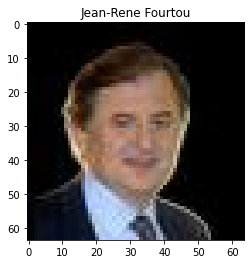

In [ ]:
#Random visszaad egy kepet nevvel, kesobb tanulasnal hasznalva
def choose_random():
  global image_paths
  
  rand = randint(0, len(image_paths)-1)
  path = image_paths[rand]

  name = path.split('/')[5]

  img = Image.open(path)

  array = np.array(img, dtype="float32")
  array /= 255

  array = np.moveaxis(array, 2, 0)

  return (name.replace('_',' '), array)

value = choose_random()

plt.title(value[0])
plt.imshow(np.moveaxis(value[1], 0, 2))

def choose(i):
  global image_paths
  path = image_paths[i]

  name = path.split('/')[5]

  img = Image.open(path)

  array = np.array(img, dtype="float32")
  array /= 255

  array = np.moveaxis(array, 2, 0)
  return torch.Tensor(array).to(DEVICE).reshape((1,3,64,64))


# Autoencoder

## Preparing the data

Batch Size | Epochs | Learning Rate | Weight Decay | End Result
*   16 | 50 | 0.01 | 1e-5 | ~0.3 (nagyon zajos)
*   16 | 10 | 0.0001 | 1e-5 | ~0.02 (maszatos, de nagyon megragadja a lényeget)
*   16 | 10 | 0.0001 | 1e-5 | ~0.016 (hatter nelkul, maszatosabb, oltonyos ferfiak jok)


In [ ]:
BATCH_SIZE = 16
SHUFFLE = True
EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = "cuda" if cuda.is_available() else "cpu"
print(DEVICE)

class EncoderDataset(Dataset):
  def __init__(self, img_list, transform=None):
        self.img_labels = img_list
        self.img_list = img_list
        self.transform = transform
        self.target_transform = None

  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = self.img_list[idx]
      image = np.array(Image.open(img_path), dtype='float32')
      image /= 255.0

      image = np.moveaxis(image, 2, 0)

      t_image = torch.Tensor(image)

      if self.transform:
          t_image = self.transform(t_image)

      return t_image, t_image

def random_generate_shuffle(img_list, ratio=0.8):
  ids = np.random.permutation(len(img_list))
  shuffled = np.array(img_list)[ids]

  train_list = shuffled[:int(len(img_list) * ratio)]
  test_list = shuffled[int(len(img_list) * ratio):]

  return EncoderDataset(train_list) , EncoderDataset(test_list)

train_data, test_data = random_generate_shuffle(image_paths)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

cuda


## Creating the Autoencoder

In [ ]:
''' class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x '''

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64*64),
            nn.Unflatten(1,(64,8,8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(64 * 64, encoding_dim)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        enc = self.encoder(x)
        enc = enc.view(enc.size(0), -1)
        enc = self.fc(enc)
        enc = self.tanh(enc)
        dec = self.decoder(enc)
        return enc, dec

autoencoder = AutoEncoder(256).to(DEVICE)

## Training

In [ ]:
loss_fn = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

def train_loop(train_loader, ae, loss_fn, opt):
  size = len(train_loader.dataset)
  loss_value, current = 0, 0

  for batch, (X, y) in enumerate(train_loader):
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    pred = ae(X)

    planned_shape = (y.size())
    pred = torch.reshape(pred[1],planned_shape)
    loss = loss_fn(pred, y)

    X.detach()
    y.detach()   
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if batch % 10 == 0:
      loss_value, current = loss.item(), batch * len(X)
      print(f"LOSS: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
      
  loss_value = loss.item()
  print(f"LOSS: {loss_value:>7f}  [{size:>5d}/{size:>5d}]")

def test_loop(test_loader, ae, loss_fn):
  size = len(test_loader)
  test_loss = 0

  with torch.no_grad():
    for batch, (X, y) in enumerate(test_loader):
      X = X.to(DEVICE)
      y = y.to(DEVICE)
      pred = ae(X)

      planned_shape = (y.size())
      pred = torch.reshape(pred[1],planned_shape)
      loss = loss_fn(pred, y)

      test_loss += loss.item()

      X.detach()
      y.detach()
      
  test_loss /= size
  print(f"TEST LOSS: {test_loss:>7f}")

if os.path.exists('/content/autoencoder.ckpt'):
  autoencoder.load_state_dict(torch.load('/content/autoencoder.ckpt', map_location=torch.device(DEVICE)))
  autoencoder.eval()
else:
  for i in range(EPOCHS):
    print(f"\t -- Starting Epoch {i+1} -- \t")
    train_loop(train_loader, autoencoder, loss_fn, optimizer)
    test_loop(test_loader, autoencoder, loss_fn)
  torch.save(autoencoder.state_dict(), '/content/autoencoder.ckpt')

## Testing

tensor([[[8.4576e-03, 5.6018e-03, 2.7278e-03,  ..., 1.5125e-03,
          2.3316e-03, 1.4223e-02],
         [4.6786e-03, 3.1169e-03, 1.5503e-03,  ..., 2.4644e-04,
          6.5984e-04, 1.0210e-02],
         [3.9403e-03, 2.6459e-03, 1.3638e-03,  ..., 4.0633e-04,
          5.0714e-04, 5.1020e-03],
         ...,
         [5.8364e-02, 6.9821e-02, 6.5992e-02,  ..., 4.4226e-02,
          3.7511e-02, 1.0278e-01],
         [7.5984e-02, 8.2244e-02, 7.4898e-02,  ..., 6.8666e-02,
          5.4975e-02, 1.0760e-01],
         [1.1957e-01, 1.2035e-01, 1.1771e-01,  ..., 1.1122e-01,
          9.4481e-02, 1.4663e-01]],

        [[1.0975e-02, 6.0098e-03, 4.0406e-03,  ..., 1.4722e-03,
          4.0300e-03, 1.5047e-02],
         [6.7923e-03, 3.2160e-03, 2.5159e-03,  ..., 2.7262e-04,
          1.3936e-03, 5.3521e-03],
         [4.7641e-03, 1.9638e-03, 1.5653e-03,  ..., 3.3123e-04,
          1.2602e-03, 4.8477e-03],
         ...,
         [6.6071e-02, 6.0242e-02, 7.4723e-02,  ..., 3.7812e-02,
          4.726

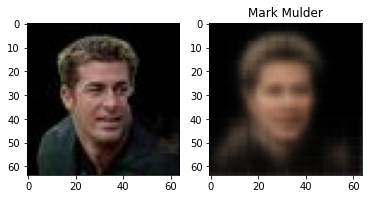

In [ ]:
name, array = choose_random()
test_tensor = torch.Tensor(array).to(DEVICE).reshape((1,3,64,64))

with torch.no_grad():
  pred = autoencoder(test_tensor)
  pred = torch.reshape(pred[1],test_tensor.size())

  print(pred[0])

  f, axarr = plt.subplots(1,2)
  plt.title(name)
  axarr[0].imshow(np.moveaxis(test_tensor.reshape(3,64,64).cpu().numpy(),0,2))
  axarr[1].imshow(np.moveaxis(pred.reshape(3,64,64).cpu().numpy(),0,2))

In [ ]:
names = np.array([pt.split('/')[5].replace('_',' ') for pt in image_paths])
reps = np.empty(shape=(len(image_paths),256))

print('Starting autoencoding')
for x in range(len(image_paths)):
  reps[x] = autoencoder(choose(x))[0].detach().to('cpu').numpy()

print('Saving')
def return_as_bytes(x):
  return json_numpy.dumps(x)

reps_as_bytes = np.apply_along_axis(return_as_bytes, axis=1, arr=reps)

df = pd.DataFrame(
    {
        'name': names,
        'fname': image_paths,
        'rep': reps_as_bytes,
    }
)

df.to_csv('representations.csv')

Starting autoencoding
Saving


In [ ]:
autoencoder.to('cpu')
autoencoder = None
torch.cuda.empty_cache()

# Recurrent network

In [ ]:
RNN_BATCH_SIZE = 16
RNN_SHUFFLE = True
RNN_EPOCHS = 50
RNN_LEARNING_RATE = 0.0001

RNN_NUM_LAYERS = 4

DEVICE = "cuda" if cuda.is_available() else "cpu"
print(DEVICE)

cpu


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Preparing the data
First we have to use the same data that we previously created using the autoencoder. That is what we will use as identification for the pictures.

In [ ]:
dataf = pd.read_csv('representations.csv')
dataf = dataf.to_numpy()

def return_as_array(x):
  return json_numpy.loads(x[0])

names = dataf[:,1]
fnames = dataf[:,2]
reps = dataf[:,3].reshape(-1,1)
reps = np.apply_along_axis(return_as_array, axis=1, arr=reps)

main_list = np.empty(names.shape, dtype=[('names', object), ('reps', np.float32, (256)), ('fnames', object)])
main_list['names'], main_list['reps'], main_list['fnames'] = names, reps, fnames

### Slicing function
This function is used for slicing up the input strings (names) to a list of 
one-hot line for each character in the name. One-hot line in this case means that we use one-hot coding for every possible character and choose the one that represents the current character then expand it to a matrix so that every row represents the place of that character in the name.

In [ ]:
all_chars = np.array([c for c in string.ascii_letters + " .'"])
line_length = all_chars.shape[0]

 
def slice_names(full_name):
  name_len = len(full_name)
  one_hot = np.zeros((name_len,line_length))
  for letter_index in range(len(full_name)):
    letter = full_name[letter_index]
    one_hot[letter_index][np.where(all_chars == letter)] = 1
  return one_hot.astype(np.float32)

def line_to_char(line):
  if (np.sum(line, axis=0)==0): return ''
  return all_chars[np.argmax(line)]

def restore_names(slices):
  name = ""
  for s in range(slices.shape[0]):
    name = name + line_to_char(slices[s])
  return name

print('Character placements:')
print(np.arange(line_length))
print('Test Data:')
print(slice_names('Alex')) # Teszteléshez / Bemutatáshoz
# A névhez bármi írható, utána a szám helyére a karakter száma kerül

print(restore_names(slice_names('Alex')))

Character placements:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
Test Data:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Alex


### Creating Dataset class

In [ ]:
def get_largest_seq():
  max = 0
  for i in main_list['names']:
    if max < len(i): max = len(i)
  return max

class RNNDataset(Dataset):
  def __init__(self, main_list, transform=None):
        padding_size = get_largest_seq()

        names = []
        for name in main_list['names']:
          sl = slice_names(name)
          names.append(np.pad(sl, ((0, padding_size - sl.shape[0]), (0, 0)) ))
        self.names = names
        self.reprs = torch.from_numpy(main_list['reps'])

  def __len__(self):
      return len(self.names)

  def __getitem__(self, idx):
      repr = self.reprs[idx]
      name = self.names[idx]

      return name, repr

### Dividing the data


In [ ]:
def random_generate_shuffle_for_rnn(main_list, ratio=0.8):  
  ids = np.random.permutation(len(main_list))
  shuffled = np.array(main_list)[ids]

  train_list = shuffled[:int(len(main_list) * ratio)]
  test_list = shuffled[int(len(main_list) * ratio):]

  return RNNDataset(train_list), RNNDataset(test_list)

train_data, test_data = random_generate_shuffle_for_rnn(main_list)

train_loader = DataLoader(train_data, batch_size=RNN_BATCH_SIZE, shuffle=RNN_SHUFFLE)
test_loader = DataLoader(test_data, batch_size=RNN_BATCH_SIZE, shuffle=RNN_SHUFFLE)

## Creating the Recurrent Neural Network
This is the part when we create an RNN that will give us back both a hidden state, and an output. The hidden state is then used as an input together with the name. The output is compared to the representation we got from the autoencoder.

For the first input we will have to give a false hidden state, so that it still follows the input schema.

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(line_length, 256, batch_first=True, num_layers=RNN_NUM_LAYERS)
        self.tanh = nn.Tanh()
        #self.linear = nn.Linear(256,256) # - [-1;1] -> [-inf, inf]
        
  def forward(self, input, hidden):
      out, h_out = self.rnn(input, hidden)
      #out = self.linear(out)
      out = self.tanh(out)
      return out, h_out

  def initHidden(self, CURRENT_BATCH_SIZE):
    return torch.zeros(RNN_NUM_LAYERS, CURRENT_BATCH_SIZE, 256, dtype=torch.float32)

rnn = RNN(line_length, 256, 256).to(DEVICE, dtype=torch.float32)

## Training

In [ ]:
opt = optim.Adam(rnn.parameters(), lr=RNN_LEARNING_RATE, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train(train_loader, rnn, loss_fn, opt):
  size = len(train_loader.dataset)
  loss_graph = np.empty((size // RNN_BATCH_SIZE) + 2)
  graph_ind = 0

  for batch, (X, y) in enumerate(train_loader):
    hidden = rnn.initHidden(X.shape[0]).to(DEVICE)

    y = y.to(DEVICE)
    X = X.to(DEVICE)

    opt.zero_grad()

    pred, hidden = rnn(X, hidden)

    loss = loss_fn(pred[:,-1,:], y)
    loss_graph[graph_ind] = loss.item()
    graph_ind += 1

    loss.backward()
    opt.step()

    if batch % 10 == 0:
      loss_value, current = loss.item(), batch * len(X)
      print(f"LOSS: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
      
  loss_value = loss.item()
  loss_graph[graph_ind] = loss_value
  graph_ind += 1
  print(f"LOSS: {loss_value:>7f}  [{size:>5d}/{size:>5d}]")

  return loss_graph, graph_ind

def test(test_loader, rnn, loss_fn):
  size = len(test_loader.dataset)
  test_loss = 0

  with torch.no_grad():
    for batch, (X, y) in enumerate(test_loader):
      hidden = rnn.initHidden(X.shape[0]).to(DEVICE)

      y = y.to(DEVICE)
      X = X.to(DEVICE)

      pred, hidden = rnn(X, hidden)

      loss = loss_fn(pred[:,-1,:], y)
      test_loss += loss.item()
      
  test_loss /= size
  print(f"TEST LOSS: {test_loss:>7f}")

if os.path.exists('/content/rnn.ckpt'):
  rnn.load_state_dict(torch.load('/content/rnn.ckpt', map_location=torch.device(DEVICE)))
  rnn.eval()
else:
  loss_full = np.empty(0)
  
  for i in range(RNN_EPOCHS):
    print(f"\t -- Starting Epoch {i+1} -- \t")
    loss_graph, graph_ind = train(train_loader, rnn, loss_fn, opt)
    loss_full = np.concatenate((loss_full, loss_graph))
    test(test_loader, rnn, loss_fn)

  plt.plot(loss_full)
  plt.show()
  torch.save(rnn.state_dict(), '/content/rnn.ckpt')

## Testing

In [ ]:
def test_one(test_name, test_rep):
  hidden = rnn.initHidden(RNN_BATCH_SIZE).to(DEVICE)
  name = test_name.numpy()
  print("Actual:",restore_names(name[0]))

  test_name = test_name.to(DEVICE)
  pred, ph = rnn(test_name, hidden)

  real_pred = pred.detach().cpu()[0,-1].numpy()

  argmin = np.argmin(np.sum(np.abs(main_list['reps'] - real_pred),axis=1))

  print("Closest to prediction:",main_list['names'][argmin])

t_n, t_p = next(iter(test_loader))
test_one(t_n, t_p)

Actual: Priyanka Chopra
Closest to prediction: Alejandro Toledo


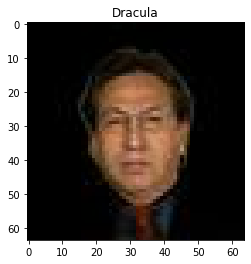

In [ ]:
def find_picture(real_name):
  name = torch.from_numpy(slice_names(real_name))[None, :, :].to(DEVICE)
  hidden = rnn.initHidden(1).to(DEVICE)

  pred, hidden = rnn(name, hidden)
  pred_np = pred.detach().cpu().numpy()
  last_pred = pred_np[0,-1,:]

  # MSE - not good
  ''' diff = main_list['reps']-last_pred
  sqr = np.square(diff)
  sum = np.sum(sqr, axis=1)
  sqrt = np.sqrt(sum)
  pic_id = np.argmin(sqrt) '''

  # MAE
  diff = main_list['reps']-last_pred
  abs = np.abs(diff)
  sum = np.sum(abs, axis=1)
  div = sum/sum.shape
  pic_id = np.argmin(div)

  path = main_list['fnames'][pic_id]
  img = Image.open(path)

  array = np.array(img, dtype="float32")
  array /= 255
  plt.title(real_name)
  plt.imshow(array)
  

find_picture("Dracula")